# FEMA Data: Modeling

This notebook picks up after the preprocessing step.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read in cleaned dataset
df = pd.read_csv('claimsdata_preprocessed.csv')
df.head()

,basefloodelevation,policycount,elevationdifference,lowestadjacentgrade,lowestfloorelevation,numberoffloorsintheinsuredbuilding,amountpaidonbuildingclaim,amountpaidoncontentsclaim,amountpaidonincreasedcostofcomplianceclaim,totalbuildinginsurancecoverage,...,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_not_given
0,8.0,1.0,999.0,0.0,10.0,4.0,0.00,0.0,0.0,200000.0,...,0,0,0,0,0,0,0,0,0,0
1,8.0,1.0,999.0,0.0,10.0,2.0,0.00,0.0,0.0,100000.0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,1.0,999.0,0.0,10.0,1.0,8813.21,1720.0,0.0,100000.0,...,0,0,0,0,0,0,0,0,0,0
3,8.0,1.0,999.0,0.0,10.0,2.0,2906.00,0.0,0.0,100000.0,...,0,0,0,0,0,0,0,0,0,0
4,8.0,1.0,999.0,0.0,10.0,1.0,3875.53,1545.0,0.0,100000.0,...,0,0,0,0,0,0,0,0,0,0


### Set up data for modeling

Start by separating df into X and y variables. Note to drop features that were derived from response variable.

In [3]:
X = df.drop(columns=['amountpaidonbuildingclaim', 'amountpaidonbuildingclaim_NaN', 'amountpaidoncontentsclaim', 'amountpaidoncontentsclaim_NaN', 'amountpaidonincreasedcostofcomplianceclaim', 'amountpaidonincreasedcostofcomplianceclaim_NaN'])
y = df[['amountpaidonbuildingclaim']]

Split dataset into train and test sets

In [4]:
from sklearn.model_selection import train_test_split

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

Fit robust scaler to the training set and then transform both training and test sets. Note use of Robust Scaler because this dataset has outliers.

In [5]:
from sklearn.preprocessing import RobustScaler

# intiate scaler, fit and transform
scaler = RobustScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Initial model fitting: Linear Regression

Start by fitting a simple linear regression model to the dataset.

In [6]:
from sklearn.linear_model import LinearRegression

# fit regressor to train data
LR = LinearRegression()
LR.fit(X_train_scaled, y_train)

# predict on test set
y_pred = LR.predict(X_test_scaled)

Set up metrics to track performance of different models

In [7]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# set up metrics dataframe
cols = ['Model','MSE', 'MAE', 'R2', 'Hyperparameters']

# add metrics for initial linear regression model
metrics = pd.DataFrame([['Initial Linear Regression', mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred), 'None']],  columns=cols)

In [8]:
metrics

,Model,MSE,MAE,R2,Hyperparameters
0,Initial Linear Regression,2.666468e+09,24587.314699,0.043978,None


Explore results of initial linear regression by looking at residual plots with respect to continuous variables.

elevationdifference: note anomalies around 0 and 1000. Consider new feature engineering to further capture this pattern.

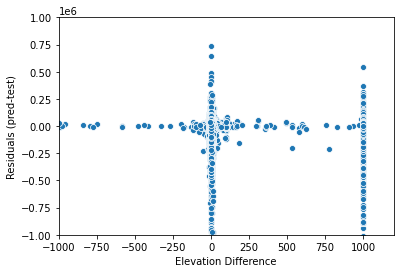

In [9]:
# plotting residuals on elevation difference

residuals = (y_pred - y_test)

_ = sns.scatterplot(x=np.array(X_test)[:,2], y=np.squeeze(residuals))
_ = plt.xlim(-1000, 1200)
_ = plt.ylim(-1000000, 1000000)
_ = plt.ylabel('Residuals (pred-test)')
_ = plt.xlabel('Elevation Difference')
plt.show()

basefloodelevation: note some very large outliers. In general, large various around 0. The model seems to predict better as BFE gets larger. Model also seems to underpredict (test values > pred values). Consider for feature engineering.

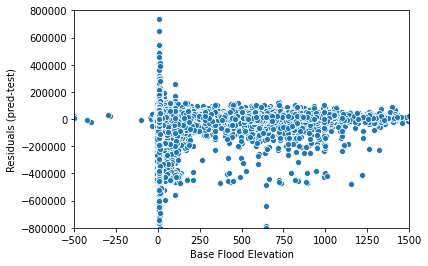

In [10]:
# plotting residuals on base flood elevation

residuals = (y_pred - y_test)

_ = sns.scatterplot(x=np.array(X_test)[:,0], y=np.squeeze(residuals))
_ = plt.xlim(-500, 1500)
_ = plt.ylim(-800000, 800000)
_ = plt.ylabel('Residuals (pred-test)')
_ = plt.xlabel('Base Flood Elevation')
plt.show()

lowestadjacentgrade and lowestfloorelevation show similar patterns

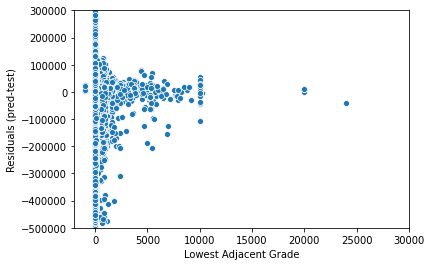

In [11]:
# plotting residuals on lowest adjacent grade

residuals = (y_pred - y_test)

_ = sns.scatterplot(x=np.array(X_test)[:,3], y=np.squeeze(residuals))
_ = plt.xlim(-2000, 30000)
_ = plt.ylim(-500000, 300000)
_ = plt.ylabel('Residuals (pred-test)')
_ = plt.xlabel('Lowest Adjacent Grade')
plt.show()

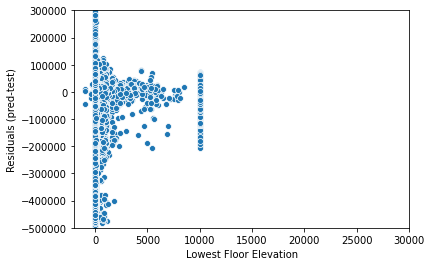

In [12]:
# plotting residuals on lowest floor elevation

residuals = (y_pred - y_test)

_ = sns.scatterplot(x=np.array(X_test)[:,4], y=np.squeeze(residuals))
_ = plt.xlim(-2000, 30000)
_ = plt.ylim(-500000, 300000)
_ = plt.ylabel('Residuals (pred-test)')
_ = plt.xlabel('Lowest Floor Elevation')
plt.show()

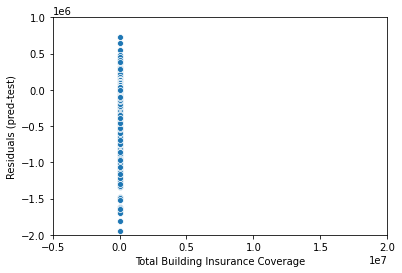

In [13]:
# plotting residuals on total insurance value

residuals = (y_pred - y_test)

_ = sns.scatterplot(x=np.array(X_test)[:,8], y=np.squeeze(residuals))
_ = plt.xlim(-5000000, 20000000)
_ = plt.ylim(-2000000, 1000000)
_ = plt.ylabel('Residuals (pred-test)')
_ = plt.xlabel('Total Building Insurance Coverage')
plt.show()

totalcontentscoverage: seems to show 2 different slopes, a very slightly negative slope when total contents coverage is less than 180,000 and slightly positive slope at larger values. Consider for feature engineering.

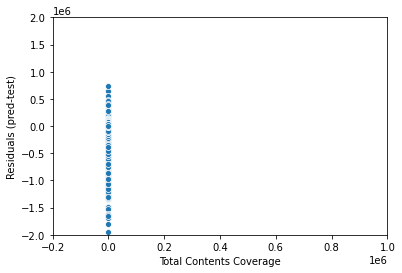

In [14]:
# plotting residuals on total contents coverage

residuals = (y_pred - y_test)

_ = sns.scatterplot(x=np.array(X_test)[:,9], y=np.squeeze(residuals))
_ = plt.xlim(-200000, 1000000)
_ = plt.ylim(-2000000, 2000000)
_ = plt.ylabel('Residuals (pred-test)')
_ = plt.xlabel('Total Contents Coverage')
plt.show()

### Additional Feature Engineering

Based on the initial linear regression model and the residual plots, there may be some additional features which will help the model to better describe the dataset. Add new features and then iterate on the linear regression with those additional features.

In [15]:
# elevation difference, add binary feature if elevation difference is near 0 or 1000
def ED_f(df):
    if df['elevationdifference'] == 0:
        val = 1
    elif df['elevationdifference'] == 1000:
        val = 1
    else:
        val = 0
    return val

df['elevdiff_binary'] = df.apply(ED_f, axis=1)

In [16]:
# base flood elevation, add binary feature if BFE is 0
def BFE_f(df):
    if df['basefloodelevation'] < 125 and df['basefloodelevation'] > -25:
        val = 1
    else:
        val = 0
    return val

df['bfe_binary'] = df.apply(BFE_f, axis=1)

In [17]:
# totalcontentscoverage, add binary feature if less than/greater than 18000
def TCC_f(df):
    if df['totalcontentsinsurancecoverage'] < 180000:
        val = 1
    else:
        val = 0
    return val

df['TCC_binary'] = df.apply(TCC_f, axis=1)

Using new df, reseparate X and y variables and split into train and test set, then apply robust scaler.

In [18]:
# separate into X and y
X = df.drop(columns=['amountpaidonbuildingclaim', 'amountpaidonbuildingclaim_NaN', 'amountpaidoncontentsclaim', 'amountpaidoncontentsclaim_NaN', 'amountpaidonincreasedcostofcomplianceclaim', 'amountpaidonincreasedcostofcomplianceclaim_NaN'])
y = df[['amountpaidonbuildingclaim']]

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# intiate scaler, fit and transform
scaler = RobustScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Refit a new linear regression model with the improved dataset and evaluate any difference in performance.

In [19]:
# fit regressor to train data
LR2 = LinearRegression()
LR2.fit(X_train_scaled, y_train)

# predict on test set
y_pred = LR2.predict(X_test_scaled)

In [20]:
# add metrics for second linear regression model
metrics = metrics.append({'Model':'Linear Regression_New Features', 'MSE': mean_squared_error(y_test, y_pred), 'MAE':mean_absolute_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'Hyperparameters':'None'}, ignore_index=True)
metrics

,Model,MSE,MAE,R2,Hyperparameters
0,Initial Linear Regression,2.666468e+09,24587.314699,0.043978,None
1,Linear Regression_New Features,2.653276e+09,24575.968570,0.048708,None


Some improvement noticed, R2 value went up and MSE decreased slightly, MAE increased slightly.

### Second model fitting: Ridge Regression

The initial Linear Regression model improved slightly with the new feature engineering, but still did not show great predictive power. Attempt to fit a Ridge Regression to see if metrics continue to improve. Try with several values of alpha for some preliminary hyperparameter tuning.

In [21]:
from sklearn.linear_model import Ridge

# first ridge regression model with alpha = 0.1
RG_1 = Ridge(alpha=0.1)
RG_1.fit(X_train_scaled, y_train)

# predict on test set
y_pred = RG_1.predict(X_test_scaled)

In [22]:
# add metrics for first ridge regression model
metrics = metrics.append({'Model':'Ridge Regression_alpha 0.1', 'MSE': mean_squared_error(y_test, y_pred), 'MAE':mean_absolute_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'Hyperparameters':str(RG_1)}, ignore_index=True)
metrics

,Model,MSE,MAE,R2,Hyperparameters
0,Initial Linear Regression,2.666468e+09,24587.314699,0.043978,None
1,Linear Regression_New Features,2.653276e+09,24575.968570,0.048708,None
2,Ridge Regression_alpha 0.1,2.653272e+09,24575.948201,0.048710,"Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr..."


In [23]:
# second ridge regression model with alpha = 1.0
RG_2 = Ridge(alpha=1.0)
RG_2.fit(X_train_scaled, y_train)

# predict on test set
y_pred = RG_2.predict(X_test_scaled)

# add metrics for second ridge regression model
metrics = metrics.append({'Model':'Ridge Regression_alpha 1.0', 'MSE': mean_squared_error(y_test, y_pred), 'MAE':mean_absolute_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'Hyperparameters':str(RG_2)}, ignore_index=True)
metrics

,Model,MSE,MAE,R2,Hyperparameters
0,Initial Linear Regression,2.666468e+09,24587.314699,0.043978,None
1,Linear Regression_New Features,2.653276e+09,24575.968570,0.048708,None
2,Ridge Regression_alpha 0.1,2.653272e+09,24575.948201,0.048710,"Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr..."
3,Ridge Regression_alpha 1.0,2.653247e+09,24575.801688,0.048719,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr..."


In [24]:
# third ridge regression model with alpha = 10.0
RG_3 = Ridge(alpha=10.0)
RG_3.fit(X_train_scaled, y_train)

# predict on test set
y_pred = RG_3.predict(X_test_scaled)

# add metrics for third ridge regression model
metrics = metrics.append({'Model':'Ridge Regression_alpha 10.0', 'MSE': mean_squared_error(y_test, y_pred), 'MAE':mean_absolute_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'Hyperparameters':str(RG_3)}, ignore_index=True)
metrics

,Model,MSE,MAE,R2,Hyperparameters
0,Initial Linear Regression,2.666468e+09,24587.314699,0.043978,None
1,Linear Regression_New Features,2.653276e+09,24575.968570,0.048708,None
2,Ridge Regression_alpha 0.1,2.653272e+09,24575.948201,0.048710,"Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr..."
3,Ridge Regression_alpha 1.0,2.653247e+09,24575.801688,0.048719,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr..."
4,Ridge Regression_alpha 10.0,2.652939e+09,24575.023541,0.048829,"Ridge(alpha=10.0, copy_X=True, fit_intercept=T..."


The ridge model with alpha = 10.0 seemed to perform the best out of all three ridge models and slightly better than the linear regression models. However, these improvements are relatively minor. 

### Third model fitting: Decision Tree Regressor

Decision tree may perform better than linear and ridge regressions. Attempt a decision tree with various max_depth values.

In [25]:
from sklearn.tree import DecisionTreeRegressor

# try decision tree with defaults, no max_depth
DT1 = DecisionTreeRegressor()
DT1.fit(X_train_scaled, y_train)

# predict on test set
y_pred = DT1.predict(X_test_scaled)

# add metrics for first decision tree
metrics = metrics.append({'Model':'Decision Tree_no max depth', 'MSE': mean_squared_error(y_test, y_pred), 'MAE':mean_absolute_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'Hyperparameters':str(DT1)}, ignore_index=True)
metrics

,Model,MSE,MAE,R2,Hyperparameters
0,Initial Linear Regression,2.666468e+09,24587.314699,0.043978,None
1,Linear Regression_New Features,2.653276e+09,24575.968570,0.048708,None
2,Ridge Regression_alpha 0.1,2.653272e+09,24575.948201,0.048710,"Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr..."
3,Ridge Regression_alpha 1.0,2.653247e+09,24575.801688,0.048719,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr..."
4,Ridge Regression_alpha 10.0,2.652939e+09,24575.023541,0.048829,"Ridge(alpha=10.0, copy_X=True, fit_intercept=T..."
5,Decision Tree_no max depth,2.594953e+09,20628.905221,0.069619,"DecisionTreeRegressor(criterion='mse', max_dep..."


In [26]:
# get depth for the initial decision tree for comparison
DT1.get_depth()

71

In [27]:
# try decision tree with max_depth = 20
DT2 = DecisionTreeRegressor(max_depth=20)
DT2.fit(X_train_scaled, y_train)

# predict on test set
y_pred = DT2.predict(X_test_scaled)

# add metrics for second decision tree
metrics = metrics.append({'Model':'Decision Tree_max depth 20', 'MSE': mean_squared_error(y_test, y_pred), 'MAE':mean_absolute_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'Hyperparameters':str(DT2)}, ignore_index=True)
metrics

,Model,MSE,MAE,R2,Hyperparameters
0,Initial Linear Regression,2.666468e+09,24587.314699,0.043978,None
1,Linear Regression_New Features,2.653276e+09,24575.968570,0.048708,None
2,Ridge Regression_alpha 0.1,2.653272e+09,24575.948201,0.048710,"Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr..."
3,Ridge Regression_alpha 1.0,2.653247e+09,24575.801688,0.048719,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr..."
4,Ridge Regression_alpha 10.0,2.652939e+09,24575.023541,0.048829,"Ridge(alpha=10.0, copy_X=True, fit_intercept=T..."
5,Decision Tree_no max depth,2.594953e+09,20628.905221,0.069619,"DecisionTreeRegressor(criterion='mse', max_dep..."
6,Decision Tree_max depth 20,1.967159e+09,17738.136575,0.294705,"DecisionTreeRegressor(criterion='mse', max_dep..."


The initial decision tree without a max depth limit grew to a depth of 80. Trying a decision tree with a max depth of 20 improved significantly on both MSE and R2 metrics. Attempt with an even smaller max depth.

In [28]:
# try decision tree with max_depth = 5
DT3 = DecisionTreeRegressor(max_depth=5)
DT3.fit(X_train_scaled, y_train)

# predict on test set
y_pred = DT3.predict(X_test_scaled)

# add metrics for third decision tree
metrics = metrics.append({'Model':'Decision Tree_max depth 5', 'MSE': mean_squared_error(y_test, y_pred), 'MAE':mean_absolute_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'Hyperparameters':str(DT3)}, ignore_index=True)
metrics

,Model,MSE,MAE,R2,Hyperparameters
0,Initial Linear Regression,2.666468e+09,24587.314699,0.043978,None
1,Linear Regression_New Features,2.653276e+09,24575.968570,0.048708,None
2,Ridge Regression_alpha 0.1,2.653272e+09,24575.948201,0.048710,"Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr..."
3,Ridge Regression_alpha 1.0,2.653247e+09,24575.801688,0.048719,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr..."
4,Ridge Regression_alpha 10.0,2.652939e+09,24575.023541,0.048829,"Ridge(alpha=10.0, copy_X=True, fit_intercept=T..."
5,Decision Tree_no max depth,2.594953e+09,20628.905221,0.069619,"DecisionTreeRegressor(criterion='mse', max_dep..."
6,Decision Tree_max depth 20,1.967159e+09,17738.136575,0.294705,"DecisionTreeRegressor(criterion='mse', max_dep..."
7,Decision Tree_max depth 5,2.289240e+09,22923.252008,0.179228,"DecisionTreeRegressor(criterion='mse', max_dep..."


A max depth of 5 had slightly worse performance. Consider further hyperparameter tuning around max depth of 20.

### Fourth model fitting: Random Forest Regressor

Decision tree regressor appears to perform better than linear or ridge regression. Explore an ensemble method like random forest before deciding which model to move forward with.

In [29]:
from sklearn.ensemble import RandomForestRegressor

# try random forest using max_depth=20
RF1 = RandomForestRegressor(max_depth=20)
RF1.fit(X_train_scaled, np.squeeze(y_train))

# predict on test set
y_pred = RF1.predict(X_test_scaled)

# add metrics for first random forest
metrics = metrics.append({'Model':'Random Forest_estimators 10', 'MSE': mean_squared_error(y_test, y_pred), 'MAE':mean_absolute_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'Hyperparameters':str(RF1)}, ignore_index=True)
metrics

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Model,MSE,MAE,R2,Hyperparameters
0,Initial Linear Regression,2.666468e+09,24587.314699,0.043978,None
1,Linear Regression_New Features,2.653276e+09,24575.968570,0.048708,None
2,Ridge Regression_alpha 0.1,2.653272e+09,24575.948201,0.048710,"Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr..."
3,Ridge Regression_alpha 1.0,2.653247e+09,24575.801688,0.048719,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr..."
4,Ridge Regression_alpha 10.0,2.652939e+09,24575.023541,0.048829,"Ridge(alpha=10.0, copy_X=True, fit_intercept=T..."
5,Decision Tree_no max depth,2.594953e+09,20628.905221,0.069619,"DecisionTreeRegressor(criterion='mse', max_dep..."
6,Decision Tree_max depth 20,1.967159e+09,17738.136575,0.294705,"DecisionTreeRegressor(criterion='mse', max_dep..."
7,Decision Tree_max depth 5,2.289240e+09,22923.252008,0.179228,"DecisionTreeRegressor(criterion='mse', max_dep..."
8,Random Forest_estimators 10,1.609599e+09,17103.133113,0.422903,"RandomForestRegressor(bootstrap=True, criterio..."


The random forest regressor performed better than the single decision tree using the same max depth. Attempt hyperparameter tuning on the random forest model to try improving on this model even further. Using a one-by-one approach rather than grid/random searchCV.

In [30]:
# Try a few values of n_estimators

# n_estimators = 50
RF2 = RandomForestRegressor(max_depth=20, n_estimators=50)
RF2.fit(X_train_scaled, np.squeeze(y_train))

# predict on test set
y_pred = RF2.predict(X_test_scaled)

# add metrics for first random forest
metrics = metrics.append({'Model':'Random Forest_estimators 50', 'MSE': mean_squared_error(y_test, y_pred), 'MAE':mean_absolute_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'Hyperparameters':str(RF2)}, ignore_index=True)
metrics

,Model,MSE,MAE,R2,Hyperparameters
0,Initial Linear Regression,2.666468e+09,24587.314699,0.043978,None
1,Linear Regression_New Features,2.653276e+09,24575.968570,0.048708,None
2,Ridge Regression_alpha 0.1,2.653272e+09,24575.948201,0.048710,"Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr..."
3,Ridge Regression_alpha 1.0,2.653247e+09,24575.801688,0.048719,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr..."
4,Ridge Regression_alpha 10.0,2.652939e+09,24575.023541,0.048829,"Ridge(alpha=10.0, copy_X=True, fit_intercept=T..."
5,Decision Tree_no max depth,2.594953e+09,20628.905221,0.069619,"DecisionTreeRegressor(criterion='mse', max_dep..."
6,Decision Tree_max depth 20,1.967159e+09,17738.136575,0.294705,"DecisionTreeRegressor(criterion='mse', max_dep..."
7,Decision Tree_max depth 5,2.289240e+09,22923.252008,0.179228,"DecisionTreeRegressor(criterion='mse', max_dep..."
8,Random Forest_estimators 10,1.609599e+09,17103.133113,0.422903,"RandomForestRegressor(bootstrap=True, criterio..."
9,Random Forest_estimators 50,1.516830e+09,16968.584523,0.456163,"RandomForestRegressor(bootstrap=True, criterio..."


In [31]:
# n_estimators = 100
RF3 = RandomForestRegressor(max_depth=20, n_estimators=100)
RF3.fit(X_train_scaled, np.squeeze(y_train))

# predict on test set
y_pred = RF3.predict(X_test_scaled)

# add metrics for first random forest
metrics = metrics.append({'Model':'Random Forest_estimators 100', 'MSE': mean_squared_error(y_test, y_pred), 'MAE':mean_absolute_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'Hyperparameters':str(RF3)}, ignore_index=True)
metrics

# export metrics dataframe
metrics.to_csv('metrics.csv', index=False)

In [32]:
# explore feature importances
feat_imp = pd.DataFrame({'feature':X.columns, 'importance':RF3.feature_importances_})
feat_imp.sort_values(by=['importance'], ascending=False).head(20)

# export feature importances
feat_imp.to_csv('feature_importances.csv', index=False)

In [33]:
# This was the randomized search CV to attempt hyperparameter tuning automatically.
# This was too computationally intense for my computer to run.

#from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import randint

# set up model parameters dict for random search, only trying two parameters

#model_params = {
   # 'n_estimators': randint(5, 200),
    #'max_depth': randint(10, 75)
#}

# create random forest regressor model
#RF_model = RandomForestRegressor()

# implement randomized search CV
#RF_CV = RandomizedSearchCV(RF_model, model_params, n_iter=10, cv=3, random_state=123)
#model = RF_CV.fit(X_train_scaled, y_train)

# get best hyperparameters
#model.best_estimator_.get_params()

In [35]:
metrics['RMSE'] = np.sqrt(metrics['MSE'])
metrics

,Model,MSE,MAE,R2,Hyperparameters,RMSE
0,Initial Linear Regression,2.666468e+09,24587.314699,0.043978,None,51637.851494
1,Linear Regression_New Features,2.653276e+09,24575.968570,0.048708,None,51509.955715
2,Ridge Regression_alpha 0.1,2.653272e+09,24575.948201,0.048710,"Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr...",51509.922542
3,Ridge Regression_alpha 1.0,2.653247e+09,24575.801688,0.048719,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",51509.674187
4,Ridge Regression_alpha 10.0,2.652939e+09,24575.023541,0.048829,"Ridge(alpha=10.0, copy_X=True, fit_intercept=T...",51506.687010
5,Decision Tree_no max depth,2.594953e+09,20628.905221,0.069619,"DecisionTreeRegressor(criterion='mse', max_dep...",50940.682618
6,Decision Tree_max depth 20,1.967159e+09,17738.136575,0.294705,"DecisionTreeRegressor(criterion='mse', max_dep...",44352.663573
7,Decision Tree_max depth 5,2.289240e+09,22923.252008,0.179228,"DecisionTreeRegressor(criterion='mse', max_dep...",47845.999890
8,Random Forest_estimators 10,1.609599e+09,17103.133113,0.422903,"RandomForestRegressor(bootstrap=True, criterio...",40119.804842
9,Random Forest_estimators 50,1.516830e+09,16968.584523,0.456163,"RandomForestRegressor(bootstrap=True, criterio...",38946.508137


In [36]:
metrics = metrics[['Model', 'RMSE', 'MSE', 'MAE', 'R2', 'Hyperparameters']]
metrics

,Model,RMSE,MSE,MAE,R2,Hyperparameters
0,Initial Linear Regression,51637.851494,2.666468e+09,24587.314699,0.043978,None
1,Linear Regression_New Features,51509.955715,2.653276e+09,24575.968570,0.048708,None
2,Ridge Regression_alpha 0.1,51509.922542,2.653272e+09,24575.948201,0.048710,"Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr..."
3,Ridge Regression_alpha 1.0,51509.674187,2.653247e+09,24575.801688,0.048719,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr..."
4,Ridge Regression_alpha 10.0,51506.687010,2.652939e+09,24575.023541,0.048829,"Ridge(alpha=10.0, copy_X=True, fit_intercept=T..."
5,Decision Tree_no max depth,50940.682618,2.594953e+09,20628.905221,0.069619,"DecisionTreeRegressor(criterion='mse', max_dep..."
6,Decision Tree_max depth 20,44352.663573,1.967159e+09,17738.136575,0.294705,"DecisionTreeRegressor(criterion='mse', max_dep..."
7,Decision Tree_max depth 5,47845.999890,2.289240e+09,22923.252008,0.179228,"DecisionTreeRegressor(criterion='mse', max_dep..."
8,Random Forest_estimators 10,40119.804842,1.609599e+09,17103.133113,0.422903,"RandomForestRegressor(bootstrap=True, criterio..."
9,Random Forest_estimators 50,38946.508137,1.516830e+09,16968.584523,0.456163,"RandomForestRegressor(bootstrap=True, criterio..."


In [38]:
import pickle
s = pickle.dumps(RF2)
from joblib import dump, load
dump(RF2, 'randomforest_model_buildingdamage.joblib') 

['randomforest_model_buildingdamage.joblib']